### Question:  Do the different days of the week have a different rate of return (for a basket of securities) over the past 10 years ?

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
%matplotlib inline

In [2]:
df = pd.read_csv('SP500.csv')
df_10 = pd.read_csv('DGS10.csv')
df_10_10 = pd.read_csv('DGS10_10.csv')
df_gold = pd.read_csv('gold.csv')
df_oil = pd.read_csv('oil.csv')
df_btc = pd.read_csv('btc.csv')


# Convert price to a number, with coersion to throw NA's if conversion not possible
df['price'] = pd.to_numeric(df.SP500, errors='coerce')
df_10['price'] = pd.to_numeric(df_10.DGS10, errors='coerce')
df_10_10['price'] = pd.to_numeric(df_10_10.DGS10, errors='coerce')
df_gold['price'] = pd.to_numeric(df_gold.GOLDAMGBD229NLBM, errors='coerce')
df_oil['price'] = pd.to_numeric(df_oil.DCOILWTICO, errors='coerce')
df_btc['price'] = pd.to_numeric(df_btc.CBBTCUSD, errors='coerce')


# Remove NA's
df.dropna(inplace=True)
df_10.dropna(inplace=True)
df_10_10.dropna(inplace=True)
df_gold.dropna(inplace=True)
df_oil.dropna(inplace=True)
df_btc.dropna(inplace=True)

In [3]:
df.head()

,DATE,SP500,price
0,2009-06-26,918.90,918.90
1,2009-06-29,927.23,927.23
2,2009-06-30,919.32,919.32
3,2009-07-01,923.33,923.33
4,2009-07-02,896.42,896.42


In [4]:
df_10.head()

,DATE,DGS10,price
0,1962-01-02,4.06,4.06
1,1962-01-03,4.03,4.03
2,1962-01-04,3.99,3.99
3,1962-01-05,4.02,4.02
4,1962-01-08,4.03,4.03


In [5]:
df_10_10.head()

,DATE,DGS10,price
0,2009-06-26,3.52,3.52
1,2009-06-29,3.51,3.51
2,2009-06-30,3.53,3.53
3,2009-07-01,3.55,3.55
4,2009-07-02,3.51,3.51


In [6]:
df_gold.head()

,DATE,GOLDAMGBD229NLBM,price
0,2009-06-26,572.566,572.566
1,2009-06-29,570.133,570.133
2,2009-06-30,566.697,566.697
3,2009-07-01,567.296,567.296
4,2009-07-02,571.708,571.708


In [7]:
print(df_gold.columns)
print(df_gold.dtypes)

Index(['DATE', 'GOLDAMGBD229NLBM', 'price'], dtype='object')
DATE                 object
GOLDAMGBD229NLBM     object
price               float64
dtype: object


In [8]:
df_btc.head()

,DATE,CBBTCUSD,price
0,2014-12-01,370,370.0
1,2014-12-02,378,378.0
2,2014-12-03,378,378.0
3,2014-12-04,377.1,377.1
5,2014-12-06,378,378.0


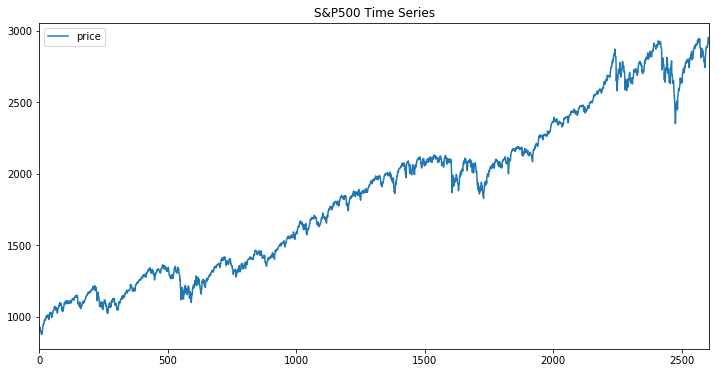

In [9]:
df.plot(figsize=(12, 6))
plt.title('S&P500 Time Series')
plt.show()

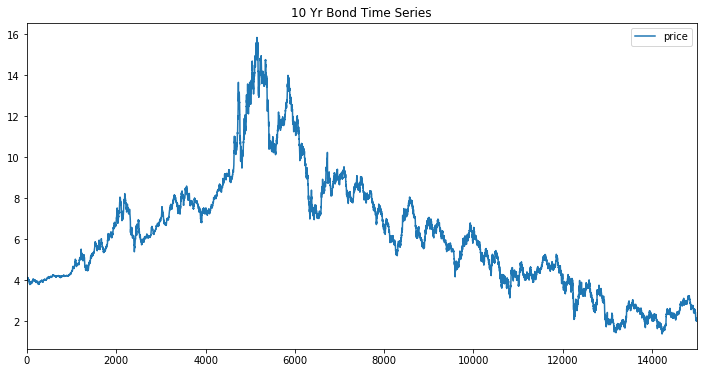

In [10]:
df_10.plot(figsize=(12, 6))
plt.title('10 Yr Bond Time Series')
plt.show()

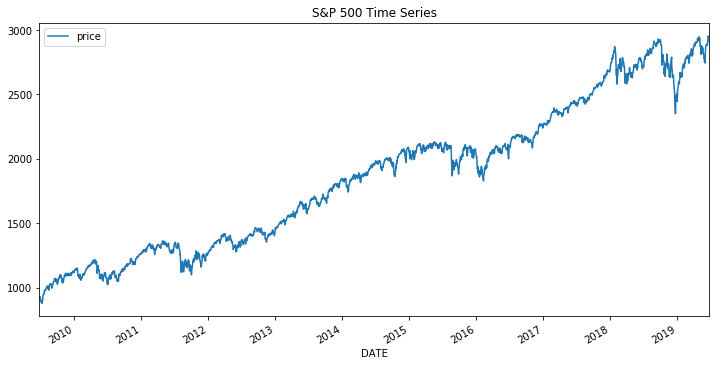

In [11]:
df.index = pd.to_datetime(df.DATE)
df.plot(figsize=(12, 6))
plt.title('S&P 500 Time Series')
plt.show()

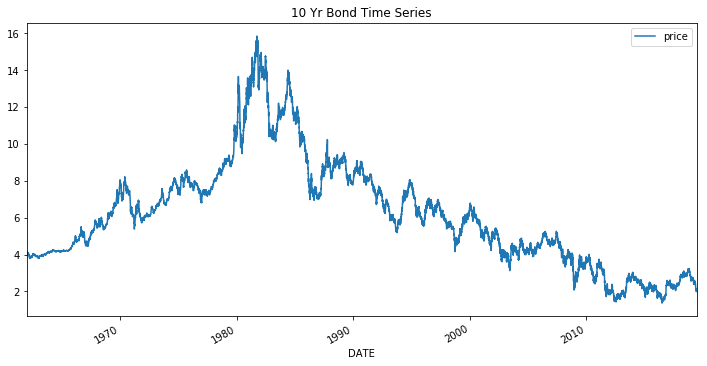

In [12]:
df_10.index = pd.to_datetime(df_10.DATE)
df_10.plot(figsize=(12, 6))
plt.title('10 Yr Bond Time Series')
plt.show()

In [13]:
print(df.dtypes)
print(df_10.dtypes)

DATE      object
SP500     object
price    float64
dtype: object
DATE      object
DGS10     object
price    float64
dtype: object


The next step separates the weekday, day of month, month and year from the date object.

In [14]:
# For S&P 500
df['date_time'] = pd.to_datetime(df['DATE'])

df['weekday'] = df.date_time.dt.weekday
df['day'] = df.date_time.dt.day
df['month'] = df.date_time.dt.month
df['year'] = df.date_time.dt.year

# For 10 Yr Bond
df_10['date_time'] = pd.to_datetime(df_10['DATE'])

df_10['weekday'] = df_10.date_time.dt.weekday
df_10['day'] = df_10.date_time.dt.day
df_10['month'] = df_10.date_time.dt.month
df_10['year'] = df_10.date_time.dt.year

# For 10 Yr Bond (last 10 years only)
df_10_10['date_time'] = pd.to_datetime(df_10_10['DATE'])

df_10_10['weekday'] = df_10_10.date_time.dt.weekday
df_10_10['day'] = df_10_10.date_time.dt.day
df_10_10['month'] = df_10_10.date_time.dt.month
df_10_10['year'] = df_10_10.date_time.dt.year

# For gold (last 10 years only)
df_gold['date_time'] = pd.to_datetime(df_gold['DATE'])

df_gold['weekday'] = df_gold.date_time.dt.weekday
df_gold['day'] = df_gold.date_time.dt.day
df_gold['month'] = df_gold.date_time.dt.month
df_gold['year'] = df_gold.date_time.dt.year

# For oil (last 10 years only)
df_oil['date_time'] = pd.to_datetime(df_oil['DATE'])

df_oil['weekday'] = df_oil.date_time.dt.weekday
df_oil['day'] = df_oil.date_time.dt.day
df_oil['month'] = df_oil.date_time.dt.month
df_oil['year'] = df_oil.date_time.dt.year

# For bitcoin
df_btc['date_time'] = pd.to_datetime(df_btc['DATE'])

df_btc['weekday'] = df_btc.date_time.dt.weekday
df_btc['day'] = df_btc.date_time.dt.day
df_btc['month'] = df_btc.date_time.dt.month
df_btc['year'] = df_btc.date_time.dt.year

0 = Monday  
1 = Tuesday  
2 = Wednesday  
3 = Thursday  
4 = Friday  

Prices are the closing price for the day listed.

In [15]:
df.tail()

,DATE,SP500,price,date_time,weekday,day,month,year
DATE,,,,,,,,
2019-06-19,2019-06-19,2926.46,2926.46,2019-06-19,2,19,6,2019
2019-06-20,2019-06-20,2954.18,2954.18,2019-06-20,3,20,6,2019
2019-06-21,2019-06-21,2950.46,2950.46,2019-06-21,4,21,6,2019
2019-06-24,2019-06-24,2945.35,2945.35,2019-06-24,0,24,6,2019
2019-06-25,2019-06-25,2917.38,2917.38,2019-06-25,1,25,6,2019


In [16]:
df_10.tail()

,DATE,DGS10,price,date_time,weekday,day,month,year
DATE,,,,,,,,
2019-06-19,2019-06-19,2.03,2.03,2019-06-19,2,19,6,2019
2019-06-20,2019-06-20,2.01,2.01,2019-06-20,3,20,6,2019
2019-06-21,2019-06-21,2.07,2.07,2019-06-21,4,21,6,2019
2019-06-24,2019-06-24,2.02,2.02,2019-06-24,0,24,6,2019
2019-06-25,2019-06-25,2.00,2.00,2019-06-25,1,25,6,2019


This next step creates a new column in the dataframe that represents the change in price per day.

In [17]:
# add a column for the change in price each day
df['change'] = df.price - df.price.shift()
df_10['change'] = df_10.price - df_10.price.shift()
df_10_10['change'] = df_10_10.price - df_10_10.price.shift()
df_gold['change'] = df_gold.price - df_gold.price.shift()
df_oil['change'] = df_oil.price - df_oil.price.shift()
df_btc['change'] = df_btc.price - df_btc.price.shift()

In [18]:
df.tail()

,DATE,SP500,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2019-06-19,2019-06-19,2926.46,2926.46,2019-06-19,2,19,6,2019,8.71
2019-06-20,2019-06-20,2954.18,2954.18,2019-06-20,3,20,6,2019,27.72
2019-06-21,2019-06-21,2950.46,2950.46,2019-06-21,4,21,6,2019,-3.72
2019-06-24,2019-06-24,2945.35,2945.35,2019-06-24,0,24,6,2019,-5.11
2019-06-25,2019-06-25,2917.38,2917.38,2019-06-25,1,25,6,2019,-27.97


In [19]:
df_10.tail()

,DATE,DGS10,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2019-06-19,2019-06-19,2.03,2.03,2019-06-19,2,19,6,2019,-0.03
2019-06-20,2019-06-20,2.01,2.01,2019-06-20,3,20,6,2019,-0.02
2019-06-21,2019-06-21,2.07,2.07,2019-06-21,4,21,6,2019,0.06
2019-06-24,2019-06-24,2.02,2.02,2019-06-24,0,24,6,2019,-0.05
2019-06-25,2019-06-25,2.00,2.00,2019-06-25,1,25,6,2019,-0.02


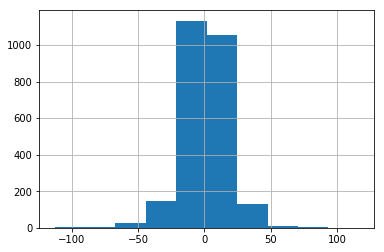

In [20]:
df.change.hist()

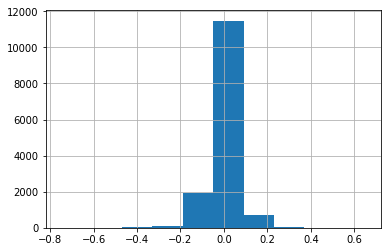

In [21]:
df_10.change.hist()

Looks like the daily change values are close to normally distributed for each security, so we can continue and check the statistical significance of the values for each day of the week.

In [22]:
df.shape

(2516, 9)

In [23]:
# For S&P 500
print(df.loc[df['weekday'] == 0, 'change'].sum())
print(df.loc[df['weekday'] == 1, 'change'].sum())
print(df.loc[df['weekday'] == 2, 'change'].sum())
print(df.loc[df['weekday'] == 3, 'change'].sum())
print(df.loc[df['weekday'] == 4, 'change'].sum())

101.3599999999933
641.9000000000053
601.8699999999991
320.37999999999533
332.9700000000071


So, this means that on Mondays, the total change in the value of the S&P 500 index was about +100.  The total change on all Tuesdays was about +640.  The next step converts the changes to an average per trading day.

In [24]:
# For 10 Yr Bond
print(df_10.loc[df_10['weekday'] == 0, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 1, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 2, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 3, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 4, 'change'].sum())

13.210000000000022
-6.320000000000043
1.0500000000000325
-2.120000000000004
-7.880000000000006


In [25]:
# Average daily move for S&P 500
print(df.loc[df['weekday'] == 0, 'change'].sum()/2516)
print(df.loc[df['weekday'] == 1, 'change'].sum()/2516)
print(df.loc[df['weekday'] == 2, 'change'].sum()/2516)
print(df.loc[df['weekday'] == 3, 'change'].sum()/2516)
print(df.loc[df['weekday'] == 4, 'change'].sum()/2516)

0.04028616852145998
0.25512718600954104
0.23921701112877547
0.12733704292527637
0.1323410174880791


In [26]:
# Average daily move for 10 Yr Bond
print(df_10.loc[df_10['weekday'] == 0, 'change'].sum()/2516)
print(df_10.loc[df_10['weekday'] == 1, 'change'].sum()/2516)
print(df_10.loc[df_10['weekday'] == 2, 'change'].sum()/2516)
print(df_10.loc[df_10['weekday'] == 3, 'change'].sum()/2516)
print(df_10.loc[df_10['weekday'] == 4, 'change'].sum()/2516)

0.005250397456279818
-0.0025119236883942935
0.00041732909379969493
-0.0008426073131955501
-0.0031319554848966637


In [27]:
# For 10 Yr Bond (just last 10 years)
print(df_10_10.loc[df_10_10['weekday'] == 0, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 1, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 2, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 3, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 4, 'change'].sum())

-0.2999999999999974
-0.09999999999999942
1.7399999999999969
-0.8699999999999986
-1.9900000000000015


In [28]:
# For gold (just last 10 years)
print(df_gold.loc[df_gold['weekday'] == 0, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 1, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 2, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 3, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 4, 'change'].sum())

538.5429999999996
415.8369999999994
-40.4830000000004
-459.0160000000003
93.1730000000016


In [29]:
# For oil (just last 10 years)
print(df_oil.loc[df_oil['weekday'] == 0, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 1, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 2, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 3, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 4, 'change'].sum())

-21.540000000000035
31.520000000000003
23.049999999999805
-30.409999999999826
-13.029999999999951


In [30]:
# For bitcoin
print(df_btc.loc[df_btc['weekday'] == 0, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 1, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 2, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 3, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 4, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 5, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 6, 'change'].sum())

1421.7199999999955
978.4300000000011
-338.36000000000377
-1088.6800000000028
5006.700000000002
6821.430000000004
-853.5099999999965


### Are these numbers significant ??

In [31]:
# For S&P 500
df['Monday'] = df.change.where(df.weekday == 0)
df['Tuesday'] = df.change.where(df.weekday == 1)
df['Wednesday'] = df.change.where(df.weekday == 2)
df['Thursday'] = df.change.where(df.weekday == 3)
df['Friday'] = df.change.where(df.weekday == 4)

In [32]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
DATE,,,,,,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33,8.33,NaN,NaN,NaN,NaN
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91,NaN,-7.91,NaN,NaN,NaN
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01,NaN,NaN,4.01,NaN,NaN
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91,NaN,NaN,NaN,-26.91,NaN


In [33]:
# For 10 Yr Bond
df_10['Monday'] = df_10.change.where(df_10.weekday == 0)
df_10['Tuesday'] = df_10.change.where(df_10.weekday == 1)
df_10['Wednesday'] = df_10.change.where(df_10.weekday == 2)
df_10['Thursday'] = df_10.change.where(df_10.weekday == 3)
df_10['Friday'] = df_10.change.where(df_10.weekday == 4)

In [34]:
df_10.head()

,DATE,DGS10,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
DATE,,,,,,,,,,,,,,
1962-01-02,1962-01-02,4.06,4.06,1962-01-02,1,2,1,1962,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,1962-01-03,4.03,4.03,1962-01-03,2,3,1,1962,-0.03,NaN,NaN,-0.03,NaN,NaN
1962-01-04,1962-01-04,3.99,3.99,1962-01-04,3,4,1,1962,-0.04,NaN,NaN,NaN,-0.04,NaN
1962-01-05,1962-01-05,4.02,4.02,1962-01-05,4,5,1,1962,0.03,NaN,NaN,NaN,NaN,0.03
1962-01-08,1962-01-08,4.03,4.03,1962-01-08,0,8,1,1962,0.01,0.01,NaN,NaN,NaN,NaN


In [35]:
# For 10 Yr Bond (last 10 years)
df_10_10['Monday'] = df_10_10.change.where(df_10_10.weekday == 0)
df_10_10['Tuesday'] = df_10_10.change.where(df_10_10.weekday == 1)
df_10_10['Wednesday'] = df_10_10.change.where(df_10_10.weekday == 2)
df_10_10['Thursday'] = df_10_10.change.where(df_10_10.weekday == 3)
df_10_10['Friday'] = df_10_10.change.where(df_10_10.weekday == 4)

In [36]:
# For gold (last 10 years)
df_gold['Monday'] = df_gold.change.where(df_gold.weekday == 0)
df_gold['Tuesday'] = df_gold.change.where(df_gold.weekday == 1)
df_gold['Wednesday'] = df_gold.change.where(df_gold.weekday == 2)
df_gold['Thursday'] = df_gold.change.where(df_gold.weekday == 3)
df_gold['Friday'] = df_gold.change.where(df_gold.weekday == 4)

In [37]:
# For oil (last 10 years)
df_oil['Monday'] = df_oil.change.where(df_oil.weekday == 0)
df_oil['Tuesday'] = df_oil.change.where(df_oil.weekday == 1)
df_oil['Wednesday'] = df_oil.change.where(df_oil.weekday == 2)
df_oil['Thursday'] = df_oil.change.where(df_oil.weekday == 3)
df_oil['Friday'] = df_oil.change.where(df_oil.weekday == 4)

# For bitcoin
df_btc['Monday'] = df_btc.change.where(df_oil.weekday == 0)
df_btc['Tuesday'] = df_btc.change.where(df_oil.weekday == 1)
df_btc['Wednesday'] = df_btc.change.where(df_oil.weekday == 2)
df_btc['Thursday'] = df_btc.change.where(df_oil.weekday == 3)
df_btc['Friday'] = df_btc.change.where(df_oil.weekday == 4)
df_btc['Saturday'] = df_btc.change.where(df_oil.weekday == 5)
df_btc['Sunday'] = df_btc.change.where(df_oil.weekday == 6)

In [68]:
df_btc.head()

,DATE,CBBTCUSD,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2014-12-01,370,370.0,2014-12-01,0,1,12,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-12-02,378,378.0,2014-12-02,1,2,12,2014,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
2,2014-12-03,378,378.0,2014-12-03,2,3,12,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-12-04,377.1,377.1,2014-12-04,3,4,12,2014,-0.9,-0.9,0.0,0.0,0.0,0.0,0.0,0.0
5,2014-12-06,378,378.0,2014-12-06,5,6,12,2014,0.9,0.0,0.0,0.9,0.0,0.0,0.0,0.0


In [39]:
df_btc = df_btc.fillna(0)

### t-test and p-values

In [40]:
# For S&P 500
ttest_ind(df['Monday'].dropna(), df['Tuesday'].dropna())

Ttest_indResult(statistic=-0.9729604233090785, pvalue=0.3308115971409148)

The pvalue is greater than .05.  Therefore, the difference in price from Monday and Tuesday, which are the two most extreme prices in the data, is not significant.  In other words the difference here is probably just due to chance and the values are taken from the same population.

In [41]:
# For 10 Yr Bond
ttest_ind(df_10['Monday'].dropna(), df_10['Friday'].dropna())

Ttest_indResult(statistic=4.070425782579718, pvalue=4.757789969930339e-05)

The pvalue is here is much less than .05.  Therefore, the difference in price from Monday and Friday, which are the two most extreme price changes in the data, is significant.  In other words the difference here is probably NOT just due to chance and the values are taken from the DIFFERENT populations.

In [42]:
# For 10 Yr Bond (last 10 years only)
ttest_ind(df_10_10['Wednesday'].dropna(), df_10_10['Friday'].dropna())

Ttest_indResult(statistic=2.2201929261497884, pvalue=0.026625706685281653)

In [43]:
# For gold (last 10 years only)
ttest_ind(df_gold['Tuesday'].dropna(), df_gold['Thursday'].dropna())

Ttest_indResult(statistic=3.3297401830221465, pvalue=0.0009001502393282731)

A null hypothesis is a hypothesis that says there is no statistical significance between the two variables in the hypothesis.  In the case of gold, since the pvalue is less than 0.05, the null hypotheses cannot be rejected and it would be likely that the two variables indeed have a statistically significant difference.

In [44]:
# For oil (last 10 years only)
ttest_ind(df_oil['Tuesday'].dropna(), df_oil['Thursday'].dropna())

Ttest_indResult(statistic=1.371972242519745, pvalue=0.17037285733436644)

In [45]:
# For bitcoin
ttest_ind(df_btc['Thursday'].dropna(), df_btc['Saturday'].dropna())

Ttest_indResult(statistic=2.3029987853710954, pvalue=0.02134134968122411)

For the case of bitcoin, there is an approximately **2.1%** probability that the difference in sums of Thursday vs. Saturday happened randomly.  Thursday was the lowest value, Saturday was the highest.

### F statistics

In [46]:
# Calc F statistic for S&P 500
F, p = stats.f_oneway(
    df['Monday'].dropna(),
    df['Tuesday'].dropna(),
    df['Wednesday'].dropna(),
    df['Thursday'].dropna(),
    df['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

0.31788075585528736
0.8661571754552783


It appears that the 5 groups (Monday, Tuesday, Wednesday, Thursday, Friday) are not likely to differ in the population (p = 0.886 which is greater than .05)

In [47]:
# Calc F statistic for 10 Yr Bond
F, p = stats.f_oneway(
    df_10['Monday'].dropna(),
    df_10['Tuesday'].dropna(),
    df_10['Wednesday'].dropna(),
    df_10['Thursday'].dropna(),
    df_10['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

5.955302563763542
8.74703589845011e-05


Here again, the p values is much less than .05 which means the data for each day are from different populations for at least 2 of the days.  In other words, the day of the week matters as it relates to price movement.  Mondays are more likely to incur a positive change in interest rate, whereas Tuesdays and Fridays are more likely to see a negative change.

In [48]:
# Calc F statistic for 10 Yr Bond (last 10 years only)
F, p = stats.f_oneway(
    df_10_10['Monday'].dropna(),
    df_10_10['Tuesday'].dropna(),
    df_10_10['Wednesday'].dropna(),
    df_10_10['Thursday'].dropna(),
    df_10_10['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

1.4622747373794742
0.2110585653345958


Not much to see here.  Looks like the difference in interest rate change from day to day the 10 Yr Bond over the last 10 years are simply due to random chance.

In [49]:
# Calc F statistic for gold (last 10 years only)
F, p = stats.f_oneway(
    df_gold['Monday'].dropna(),
    df_gold['Tuesday'].dropna(),
    df_gold['Wednesday'].dropna(),
    df_gold['Thursday'].dropna(),
    df_gold['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

3.8675627733544693
0.0038892555965370883


In [50]:
# Calc F statistic for oil (last 10 years only)
F, p = stats.f_oneway(
    df_oil['Monday'].dropna(),
    df_oil['Tuesday'].dropna(),
    df_oil['Wednesday'].dropna(),
    df_oil['Thursday'].dropna(),
    df_oil['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

0.7994683577387657
0.525397715297364


In [51]:
# Calc F statistic for bitcoin
F, p = stats.f_oneway(
    df_btc['Monday'].dropna(),
    df_btc['Tuesday'].dropna(),
    df_btc['Wednesday'].dropna(),
    df_btc['Thursday'].dropna(),
    df_btc['Friday'].dropna(),
    df_btc['Saturday'].dropna(),
    df_btc['Sunday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

1.546179669499771
0.15869572325805537


A high F value means that your data does not well support your null hypothesis. ... So a large F value indicates that a linear model is more compatible with the data than a constant average model. These predictors have high F values leading to small p values so they are sufficient for predicting the response.  

A null hypothesis is a hypothesis that says there is no statistical significance between the two variables in the hypothesis.  In the case of bitcoin, there is a roughly 16% probability that the different sums for the day of the week could have happened due to chance.

### Prepare the S&P 500 data for building a Supervised Learning model to predict the price change.

In [52]:
df['change'].fillna(0, inplace=True)

In [53]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
DATE,,,,,,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,0.00,NaN,NaN,NaN,NaN,NaN
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33,8.33,NaN,NaN,NaN,NaN
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91,NaN,-7.91,NaN,NaN,NaN
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01,NaN,NaN,4.01,NaN,NaN
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91,NaN,NaN,NaN,-26.91,NaN


In [54]:
df.drop(['DATE'], axis=1, inplace=True)
df.drop(['SP500'], axis=1, inplace=True)
df.drop(['price'], axis=1, inplace=True)
df.drop(['date_time'], axis=1, inplace=True)
df.drop(['year'], axis=1, inplace=True)
df.drop(['Monday'], axis=1, inplace=True)
df.drop(['Tuesday'], axis=1, inplace=True)
df.drop(['Wednesday'], axis=1, inplace=True)
df.drop(['Thursday'], axis=1, inplace=True)
df.drop(['Friday'], axis=1, inplace=True)

In [55]:
df.head()

,weekday,day,month,change
DATE,,,,
2009-06-26,4,26,6,0.00
2009-06-29,0,29,6,8.33
2009-06-30,1,30,6,-7.91
2009-07-01,2,1,7,4.01
2009-07-02,3,2,7,-26.91


In [56]:
df.dtypes

weekday      int64
day          int64
month        int64
change     float64
dtype: object

### Build the S&P 500 model - Linear Regression

In [57]:
# Create training and test sets.
offset = int(df.shape[0] * 0.8)

df_train = df[:offset]
df_test = df[offset:]

In [58]:
print(df_train.shape)
print(df_test.shape)

(2012, 4)
(504, 4)


In [59]:
# 1.  Linear Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LinearRegression()

# set features and dependent variable for training data
y_train = df_train['change'].values

# drop the 'target' column to obtain the feature inputs
df_train.drop(['change'], axis=1, inplace=True)

# normalize the training data
x_train = sklearn.preprocessing.normalize(df_train)

# now for test...
y_test = df_test['change'].values

# drop the 'target' column to obtain the feature inputs
df_test.drop(['change'], axis=1, inplace=True)

# normalize the test data
x_test = sklearn.preprocessing.normalize(df_test)

# fit model to training data
regr.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.129007


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [60]:
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared train:')
print(regr.score(x_train, y_train))

print('\nR-squared test:')
print(regr.score(x_test, y_test))

Coefficients: 
 [ 0.86900286 -0.88945947 -0.19400148]
Intercept: 
 1.4380390819510813

R-squared train:
0.00025570067855062995

R-squared test:
3.3742136453129845e-05


### Prepare the 10 Yr Bond data for building a Supervised Learning model to predict the price change.

In [61]:
df_10.head()

,DATE,DGS10,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
DATE,,,,,,,,,,,,,,
1962-01-02,1962-01-02,4.06,4.06,1962-01-02,1,2,1,1962,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,1962-01-03,4.03,4.03,1962-01-03,2,3,1,1962,-0.03,NaN,NaN,-0.03,NaN,NaN
1962-01-04,1962-01-04,3.99,3.99,1962-01-04,3,4,1,1962,-0.04,NaN,NaN,NaN,-0.04,NaN
1962-01-05,1962-01-05,4.02,4.02,1962-01-05,4,5,1,1962,0.03,NaN,NaN,NaN,NaN,0.03
1962-01-08,1962-01-08,4.03,4.03,1962-01-08,0,8,1,1962,0.01,0.01,NaN,NaN,NaN,NaN


In [62]:
df_10['change'].fillna(0, inplace=True)

df_10.drop(['DATE'], axis=1, inplace=True)
df_10.drop(['DGS10'], axis=1, inplace=True)
df_10.drop(['price'], axis=1, inplace=True)
df_10.drop(['date_time'], axis=1, inplace=True)
df_10.drop(['year'], axis=1, inplace=True)
df_10.drop(['Monday'], axis=1, inplace=True)
df_10.drop(['Tuesday'], axis=1, inplace=True)
df_10.drop(['Wednesday'], axis=1, inplace=True)
df_10.drop(['Thursday'], axis=1, inplace=True)
df_10.drop(['Friday'], axis=1, inplace=True)
df_10.drop(['day'], axis=1, inplace=True)
df_10.drop(['month'], axis=1, inplace=True)

In [63]:
df_10.head()

,weekday,change
DATE,,
1962-01-02,1,0.00
1962-01-03,2,-0.03
1962-01-04,3,-0.04
1962-01-05,4,0.03
1962-01-08,0,0.01


### Build the 10 Yr Bond model - Linear Regression

In [64]:
# Create training and test sets.
offset_10 = int(df_10.shape[0] * 0.8)

df_train_10 = df_10[:offset_10]
df_test_10 = df_10[offset_10:]

In [65]:
print(df_train_10.shape)
print(df_test_10.shape)

(11484, 2)
(2871, 2)


In [66]:
# 1.  Linear Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr_10 = linear_model.LinearRegression()

# set features and dependent variable for training data
y_train_10 = df_train_10['change'].values

# drop the 'target' column to obtain the feature inputs
df_train_10.drop(['change'], axis=1, inplace=True)

# normalize the training data
x_train_10 = sklearn.preprocessing.normalize(df_train_10)

# now for test...
y_test_10 = df_test_10['change'].values

# drop the 'target' column to obtain the feature inputs
df_test_10.drop(['change'], axis=1, inplace=True)

# normalize the test data
x_test_10 = sklearn.preprocessing.normalize(df_test_10)

# fit model to training data
regr_10.fit(x_train_10, y_train_10)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.109006


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [67]:
# Display the attributes we calculated.
print('Coefficients: \n', regr_10.coef_)
print('Intercept: \n', regr_10.intercept_)
print('\nR-squared train:')
print(regr_10.score(x_train_10, y_train_10))

print('\nR-squared test:')
print(regr_10.score(x_test_10, y_test_10))

Coefficients: 
 [-0.00833982]
Intercept: 
 0.006767582673497627

R-squared train:
0.002331639446182532

R-squared test:
-0.005007757394746459


R-squared value is fairly low here.  It did improve from .00081 to .0023 when the day of month and month were dropped from the data.

### Next, check for significant day of week change for just the past 10 years for the 10 Yr Bond.

### Need some WEATHER data !!!